In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tifffile
import time
import tensorflow.keras.backend as K


hue_path = '/kaggle/input/sperm25d/arriba_hue/'
for dirname, _, filenames in os.walk(hue_path):
    print(dirname)

    
value_path = '/kaggle/input/sperm25d/arriba_value/'
for dirname, _, filenames in os.walk(hue_path):
    print(dirname)

gt_path = '/kaggle/input/sperm25d/ground_truth/ground_truth/'
gt_folders = sorted(os.listdir(gt_path))
gt_folders.pop(2)
print(gt_folders[0])

def listar_paths(num_exp,exp):
    gt_path_exp = gt_path + exp
    value_tif = value_path + exp + "_arriba_value.tif"

    # Process the TIFF stacks as needed
    files_coord_flagelo = sorted(os.listdir(gt_path_exp))
    
    mask_files = []
    for i in range(len(files_coord_flagelo)):
        mask_files.append(os.path.join(gt_path_exp, files_coord_flagelo[i]))
    
    pos=0
    if (num_exp==0 or num_exp==1 or num_exp==8 or num_exp==10):
        pos = np.arange( len(files_coord_flagelo))
    else:
        pos = np.arange(1, len(files_coord_flagelo) + 1)
    vt = [value_tif] * len(pos)
    
    return list(zip(vt, pos, mask_files))

train_files = []
valid_files = []
test_files = []

for i in range(len(gt_folders)):
    
    paths = listar_paths(i,gt_folders[i])
    
    if i < 7:
        train_files += paths
    else:
        valid_files += paths
    #else:
    #    test_files += paths
        
print(train_files[0])

def preprocess_input(input_image_path, key, mask_image_path, verbose=False):
    if verbose:
        start_time = time.time()
        
    # Load and preprocess input image
    input_image = tifffile.imread(input_image_path, key=key) 

    if verbose:
        load_time = time.time()
        print("Time to load image: {} seconds".format(load_time - start_time))

    # Load and preprocess output mask image
    coords = pd.read_csv(mask_image_path)
    mat = np.zeros((480, 640))
    
    # Filter the coordinates
    coords = coords[(coords['x'] < mat.shape[0]) & (coords['y'] < mat.shape[0])]

    # Generate mask
    for _, row in coords.iterrows():
        y, x = row['y'], row['x']
        mat[y-1:y+2, x-1:x+2] = 1
    
    if verbose:
        mask_time = time.time()
        print("Time to create mask: {} seconds".format(mask_time - load_time))
    
    return input_image, mat


def data_generator(file_pairs, batch_size):
    num_samples = len(file_pairs)
    while True:
        # Shuffle the indices at the start of each epoch
        indices = np.random.permutation(num_samples)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_file_pairs = [file_pairs[j] for j in batch_indices]
            
            batch_inputs = []
            batch_masks = []
            
            for input_path, key, mask_path in batch_file_pairs:
                input_image, mask_image = preprocess_input(input_path, key, mask_path)
                batch_inputs.append(input_image)
                batch_masks.append(mask_image)
            
            batch_inputs = np.array(batch_inputs)
            batch_masks = np.array(batch_masks,dtype=int)
            
            yield batch_inputs, batch_masks


batch_size = 32
train_generator = data_generator(train_files, batch_size)
validation_generator = data_generator(valid_files, batch_size)

/kaggle/input/sperm25d/arriba_hue/
/kaggle/input/sperm25d/arriba_hue/
00-2017_05_24_SPERM_FREE_UP_Exp30
('/kaggle/input/sperm25d/arriba_value/00-2017_05_24_SPERM_FREE_UP_Exp30_arriba_value.tif', 0, '/kaggle/input/sperm25d/ground_truth/ground_truth/00-2017_05_24_SPERM_FREE_UP_Exp30/TP-010.csv')


0 36
1 36
2 36
3 36
4 36
5 36
6 36
7 36
8 36
9 36
10 36
11 36
12 36
13 36
14 36
15 36
16 36
17 36
18 36
19 36
20 36
21 36
22 36
23 36
24 36
25 36
26 36
27 36
28 36
29 36
30 36
31 36
32 36
33 36
34 36
35 36
22.449372053146362


In [15]:
# Obtain the 10th training file pair (image_path, key, mask_path)
tenth_train_file = train_files[9]  # Python uses 0-based indexing, so the 10th item is at index 9

# Unpack the file pair
image_path, key, mask_path = tenth_train_file

# Call the preprocess_input function with verbose=True
input_image, mask_image = preprocess_input(image_path, key, mask_path, verbose=True)



Time to load image: 0.005951881408691406 seconds
Time to create mask: 0.016006946563720703 seconds


In [4]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    #x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 2, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 2, strides=2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(480, 640, 1))

    # encoder: contracting path - downsample
    # 1 - downsample
    n_filters_first = 16
    f1, p1 = downsample_block(inputs, n_filters_first)
    # 2 - downsample
    f2, p2 = downsample_block(p1, n_filters_first * 2)
    # 3 - downsample
    f3, p3 = downsample_block(p2, n_filters_first * 4)
    # 3 - downsample
    #f4, p4 = downsample_block(p3, n_filters_first * 8)


    # 5 - bottleneck
    bottleneck = double_conv_block(p3, n_filters_first * 8)

    # decoder: expanding path - upsample
    #u6 = upsample_block(bottleneck, f4, n_filters_first * 8)
    
    # 7 - upsample
    u7 = upsample_block(bottleneck, f3, n_filters_first * 4)
    # 8 - upsample
    u8 = upsample_block(u7, f2, n_filters_first * 2)
    # 9 - upsample
    u9 = upsample_block(u8, f1, n_filters_first)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # U-Net model with TensorFlow's Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

def weighted_bce(ground_truth,y_pred):
    ground_truth = tf.cast(ground_truth,float)
    weights =  ground_truth * 75 + 1.
    bce = K.binary_crossentropy(ground_truth, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

checkpoint_filepath = 'unet2-5.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',  # Change to 'val_loss' to monitor weighted BCE loss
    mode='min',  # Change to 'min' since we are monitoring loss
    save_best_only=True
)



m = tf.keras.metrics.MeanIoU(num_classes=2)

def dice_loss(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice
    return dice_loss

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Add the Dice coefficient metric to your model compilation
unet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.004),
              loss=weighted_bce,#tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',dice_coefficient])

unet_model.summary()

# Start the timer

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best-performing model
)


# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1  # Print a message when the learning rate is reduced
)

start_time = time.time()

# Train the model
unet_model.fit(
    train_generator,
    steps_per_epoch=int(np.floor(len(train_files) / batch_size)),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(np.floor(len(valid_files) / batch_size)),
    callbacks=[model_checkpoint_callback,early_stopping_callback,reduce_lr_callback]
)

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print("Training time:", training_time, "seconds")

/kaggle/input/sperm25d/arriba_hue/
/kaggle/input/sperm25d/arriba_hue/
00-2017_05_24_SPERM_FREE_UP_Exp30
('/kaggle/input/sperm25d/arriba_value/00-2017_05_24_SPERM_FREE_UP_Exp30_arriba_value.tif', 0, '/kaggle/input/sperm25d/ground_truth/ground_truth/00-2017_05_24_SPERM_FREE_UP_Exp30/TP-010.csv')
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 480, 640, 16  80          ['input_4[0][0]']                
                                )                                                               

2023-06-06 08:48:04.441407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 78s 2s/step - loss: 0.4146 - accuracy: 0.9651 - dice_coefficient: 0.0201 - val_loss: 0.3031 - val_accuracy: 0.9646 - val_dice_coefficient: 0.0550 - lr: 0.0040
Epoch 2/30
36/36 [==============================] - 58s 2s/step - loss: 0.2116 - accuracy: 0.9529 - dice_coefficient: 0.0498 - val_loss: 0.2034 - val_accuracy: 0.9710 - val_dice_coefficient: 0.0822 - lr: 0.0040
Epoch 3/30
36/36 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9667 - dice_coefficient: 0.0859

KeyboardInterrupt: 

In [6]:
unet_model.fit(
    train_generator,
    steps_per_epoch=int(np.floor(len(train_files) / batch_size)),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(np.floor(len(valid_files) / batch_size)),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
30/30 [==============================] - 43s 1s/step - loss: 0.0175 - accuracy: 0.9963 - dice_coefficient: 0.5184 - val_loss: 0.0268 - val_accuracy: 0.9957 - val_dice_coefficient: 0.5200
Epoch 2/30
30/30 [==============================] - 43s 1s/step - loss: 0.0179 - accuracy: 0.9962 - dice_coefficient: 0.5166 - val_loss: 0.0234 - val_accuracy: 0.9945 - val_dice_coefficient: 0.4466
Epoch 3/30
30/30 [==============================] - 40s 1s/step - loss: 0.0180 - accuracy: 0.9961 - dice_coefficient: 0.5068 - val_loss: 0.0309 - val_accuracy: 0.9958 - val_dice_coefficient: 0.5300
Epoch 4/30
30/30 [==============================] - 43s 1s/step - loss: 0.0167 - accuracy: 0.9964 - dice_coefficient: 0.5290 - val_loss: 0.0320 - val_accuracy: 0.9959 - val_dice_coefficient: 0.5404
Epoch 5/30
30/30 [==============================] - 42s 1s/step - loss: 0.0166 - accuracy: 0.9964 - dice_coefficient: 0.5319 - val_loss: 0.0254 - val_accuracy: 0.9960 - val_dice_coefficient: 0.5271
Epoch 6/30

1/1 [==============================] - 0s 23ms/step


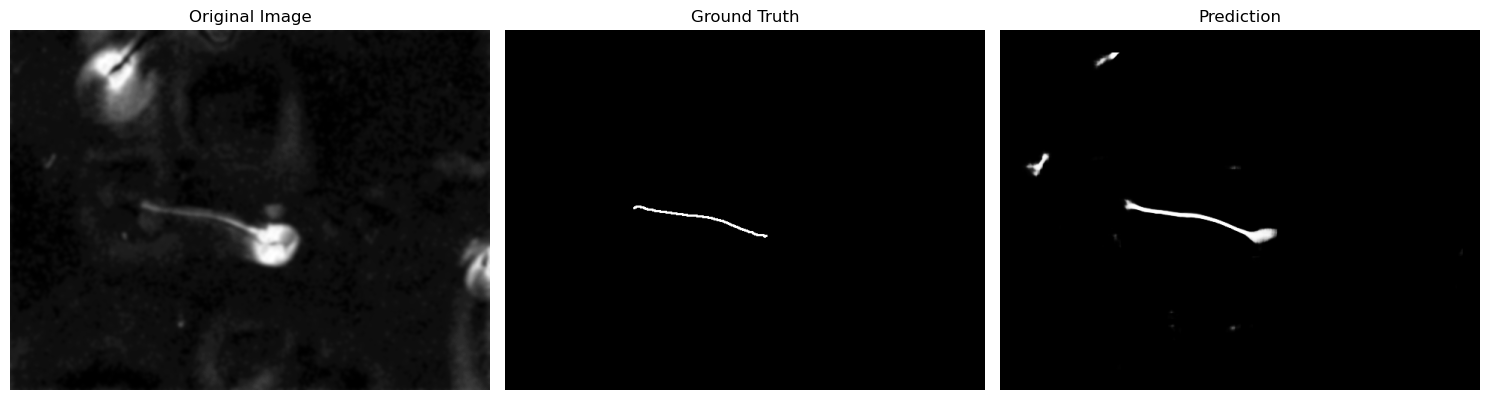

In [7]:
# Select the second training image
sample_index = 1
input_path, _, mask_path = train_files[sample_index]

# Preprocess the input image and ground truth mask
input_image, ground_truth = preprocess_input(input_path, 1, mask_path)

# Expand dimensions for prediction
input_image = np.expand_dims(input_image, axis=0)

# Generate prediction
prediction = unet_model.predict(input_image)

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(input_image[0], cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

# Ground Truth
axs[1].imshow(ground_truth, cmap="gray")
axs[1].set_title("Ground Truth")
axs[1].axis("off")

# Prediction
axs[2].imshow(prediction[0], cmap="gray")
axs[2].set_title("Prediction")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Define the file path for saving the model
model_path = 'unet2-5D.h5'

# Save the model
unet_model.save(model_path)


In [5]:
# Define the directory path for saving the model
model_dir = 'unet25D-tf/'

# Save the model in SavedModel format
tf.saved_model.save(unet_model, model_dir)


In [ ]:
history = unet_model.history

# Retrieve the training loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()